In [1]:
from pyspark.sql import  SQLContext 
from pyspark import SparkContext
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler # 특성 데이터와 관련된 처리
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
sc = SparkContext('local')
sqlctx = SQLContext(sc)

In [7]:
cardf = sqlctx.read.csv( '../RDD/data/cars.csv',
    header=True, inferSchema=True)

cardf.show()

+-----+----+
|speed|dist|
+-----+----+
|    4|   2|
|    4|  10|
|    7|   4|
|    7|  22|
|    8|  16|
|    9|  10|
|   10|  18|
|   10|  26|
|   10|  34|
|   11|  17|
|   11|  28|
|   12|  14|
|   12|  20|
|   12|  24|
|   12|  28|
|   13|  26|
|   13|  34|
|   13|  34|
|   13|  46|
|   14|  26|
+-----+----+
only showing top 20 rows



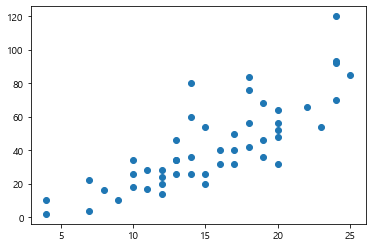

In [8]:
pdCar = cardf.toPandas()
plt.scatter(pdCar['speed'], pdCar['dist'])
plt.show()

### 자동차 속도가 15이면 제동거리가 얼마로 예측되는가?
- w와 b를 구함
    - y = wx + b ( w: 기울기, b : y절편)
- 1. 공식
- 2. 학습

In [9]:
# 상관관계 확인
cardf.corr('dist','speed')

0.8068949006892103

In [11]:
# x(자동차 속도 : feature) : 특성 데이터 / N개인 경우 (다중선형회귀), 1개인 경우 (단일선형회귀)
# y(제동 거리 : Label) : 정답

In [35]:
# 특성 데이터를 하나로 묶어줌
# inputCols : 특성 데이터들
# outputCol : 특성 데이터를을 묶어줄 컬럼 이름지정 

f = VectorAssembler(inputCols= ['speed'], outputCol='features')
v_df = f.transform(cardf)
v_df.show()

+-----+----+--------+
|speed|dist|features|
+-----+----+--------+
|    4|   2|   [4.0]|
|    4|  10|   [4.0]|
|    7|   4|   [7.0]|
|    7|  22|   [7.0]|
|    8|  16|   [8.0]|
|    9|  10|   [9.0]|
|   10|  18|  [10.0]|
|   10|  26|  [10.0]|
|   10|  34|  [10.0]|
|   11|  17|  [11.0]|
|   11|  28|  [11.0]|
|   12|  14|  [12.0]|
|   12|  20|  [12.0]|
|   12|  24|  [12.0]|
|   12|  28|  [12.0]|
|   13|  26|  [13.0]|
|   13|  34|  [13.0]|
|   13|  34|  [13.0]|
|   13|  46|  [13.0]|
|   14|  26|  [14.0]|
+-----+----+--------+
only showing top 20 rows



In [14]:
v_df.count()

50

In [36]:
v_df=v_df.select('dist','features')
v_df.show()

+----+--------+
|dist|features|
+----+--------+
|   2|   [4.0]|
|  10|   [4.0]|
|   4|   [7.0]|
|  22|   [7.0]|
|  16|   [8.0]|
|  10|   [9.0]|
|  18|  [10.0]|
|  26|  [10.0]|
|  34|  [10.0]|
|  17|  [11.0]|
|  28|  [11.0]|
|  14|  [12.0]|
|  20|  [12.0]|
|  24|  [12.0]|
|  28|  [12.0]|
|  26|  [13.0]|
|  34|  [13.0]|
|  34|  [13.0]|
|  46|  [13.0]|
|  26|  [14.0]|
+----+--------+
only showing top 20 rows



In [41]:
# train (w, b 구하는 학습용 데이터셋)
# test( test하는 데이터 셋)

# 랜덤하게 데이터 분할 70% 학습용, 30% test용
train_df, test_df = v_df.randomSplit([0.7,0.3])

In [42]:
print(test_df.count())
test_df.show()

16
+----+--------+
|dist|features|
+----+--------+
|   4|   [7.0]|
|  17|  [11.0]|
|  18|  [10.0]|
|  20|  [12.0]|
|  20|  [15.0]|
|  24|  [12.0]|
|  26|  [15.0]|
|  28|  [11.0]|
|  34|  [10.0]|
|  46|  [19.0]|
|  54|  [23.0]|
|  56|  [20.0]|
|  66|  [22.0]|
|  68|  [19.0]|
|  76|  [18.0]|
|  93|  [24.0]|
+----+--------+



### 학습

In [68]:
# 하이퍼 파라미터 : 사용자가 학습에 맞는 설정값을 지정
# maxtler : 학습할 횟수
# regParam : 러닝 레이트

lr = LinearRegression(featuresCol = 'features', 
                      labelCol='dist',
                      maxIter=100)
# 학습시작
lr_model = lr.fit(train_df) 

In [48]:
#회귀 계수값( 기울기, 절편) y=wx +b  (w,b)
print("기울기(w)",lr_model.coefficients )
print("절편(b)", lr_model.intercept )

기울기(w) [3.8172987112146144]
절편(b) -14.518527272177318


In [51]:
# 자동차 속도가 15(x)이면 제동거리는 얼마로 예측되는가?
w = lr_model.coefficients[0]
b = lr_model.intercept

# 예측값
p = w*15+b
p

42.7409533960419

### 그래프 그리기

In [54]:
pdCar = cardf.toPandas()
pdCar['lr'] = w*pdCar['speed'] + b

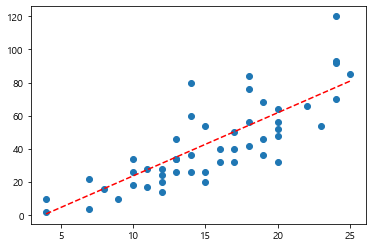

In [55]:
plt.scatter(pdCar['speed'], pdCar['dist'])
plt.plot(pdCar['speed'], pdCar['lr'],'r--')
plt.show()